In [144]:
using Flux
using Gen
using Random
using Distributions
using PyPlot
using LinearAlgebra

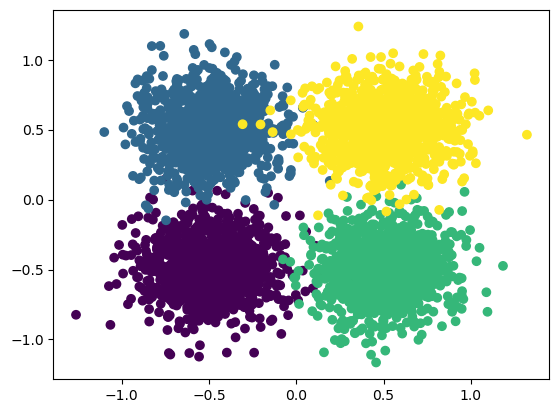

In [145]:
#Generate Data
n = 1000
Σ = [0.04 0.0; 0.0 0.04]
mu1 = [-0.5, -0.5]
mu2 = [-0.5, 0.5]
mu3 = [0.5, -0.5]
mu4 = [0.5, 0.5]

d1 = MvNormal(mu1, Σ)
d2 = MvNormal(mu2, Σ)
d3 = MvNormal(mu3, Σ)
d4 = MvNormal(mu4, Σ)

x1 = rand(d1,1000)
x2 = rand(d2,1000)
x3 = rand(d3,1000)
x4 = rand(d4,1000)
x = hcat(x1, x2, x3, x4)

labels = [Int(round(i/n % n, RoundDown) + 1) for i in range(0, 4n-1, step=1)]
y = float(Flux.onehotbatch(labels, [1,2,3,4]))
PyPlot.scatter(x[1,:],x[2,:], c=labels)

dataset = zip(Flux.unstack(transpose(x),1),Flux.unstack(transpose(y),1));

In [25]:
#Make a Neural Network
model = Chain(
  Dense(2, 5, σ),
  Dense(5, 4),
  softmax)

loss(x, y) = Flux.crossentropy(model(x), y)
opt = Flux.ADAM()

#@Flux.epochs 10 Flux.train!(loss, Flux.params(model), dataset, opt);
for i in range(1,100,step=1)
    Flux.train!(loss, Flux.params(model), dataset, opt)
    if i % 20 == 0
        predictions = mapslices(argmax,model(x),dims=1)
        labels_accurate = [x == y ? 1 : 0 for (x,y) in zip(labels,predictions)]
        accuracy = sum(labels_accurate)/(4n)
        display(accuracy)
    end
end

0.984

0.9835

0.9835

0.98425

0.984

In [146]:
predictions = mapslices(argmax,model(x),dims=1)

for i=1:length(y[1,:])
    if labels[i] != predictions[i]
        predictions[i]=5
    end
end

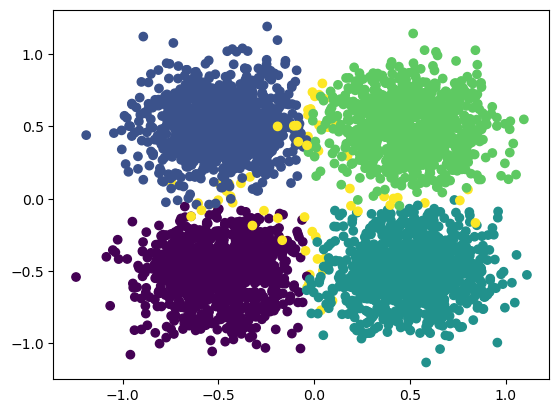

0.984

In [27]:
PyPlot.scatter(x[1,:],x[2,:], c=predictions)
labels_accurate = [x == y ? 1 : 0 for (x,y) in zip(labels,predictions)]
accuracy = sum(labels_accurate)/(4n)

In [147]:
##########
#Bayes Net
##########
function unpack(nn_params::AbstractVector)
    W₁ = reshape(nn_params[1:6], 3, 2);   
    b₁ = reshape(nn_params[7:9], 3)
    
    W₂ = reshape(nn_params[10:21], 4, 3); 
    b₂ = reshape(nn_params[22:25], 4)

    return W₁, b₁, W₂, b₂
end

# Construct a neural network using Flux and return a predicted value.
function nn_forward(xs, nn_params::AbstractVector)
    W₁, b₁, W₂, b₂ = unpack(nn_params)
    nn = Chain(Dense(W₁, b₁, tanh),
               Dense(W₂, b₂, tanh),
               softmax)
    return nn(xs)
end;

#Create a regularization term and a Gaussain prior variance term.
alpha = 0.09
sig = sqrt(1.0 / alpha)

# Specify the probabalistic model.
@gen function bayes_nn(xs, ts)
    # Create the weight and bias vector.
    μ = zeros(25)
    Σ = Diagonal(ones(25)*10)
    nn_params = @trace(mvnormal(μ,Σ), :p)
    
    # Calculate predictions for the inputs given the weights
    # and biases in theta.
    preds = nn_forward(xs, nn_params)
    
    for i=1:length(y[1,:])
        @trace(categorical(preds[:,i]), (:y, i)) 
    end
end;

trace, weight = generate(bayes_nn,(x,y))
map = get_choices(trace)
#display(map)

#Perform inference.
obs = Gen.choicemap()
    for (i, t) in enumerate(labels)
        obs[(:y, i)] = t
    end
#display(obs)


#trace, = generate(bayes_nn, (x,y), observations)
#trace

In [148]:
#Simple HMC Algorithm for Finding Likely Parameter Values
function do_inference(x, y, num_iters)
    trace, = generate(bayes_nn, (x,y), obs)
    acc = []
    ps = Array{Float64}[]
    for i=1:num_iters
        trace, accepted = hmc(trace, select(:p))
        push!(ps, trace[:p])
        push!(acc,accepted)
        if i%10 == 0
            println(sum(acc)/length(acc))
        end
    end
    return ps, acc
end


z, acc = do_inference(x,y,300)
#display(z)
display(sum(acc)/length(acc))

0.8
0.7
0.4666666666666667
0.35
0.28
0.23333333333333334
0.2
0.175
0.15555555555555556
0.14
0.12727272727272726
0.125
0.13846153846153847
0.1357142857142857
0.12666666666666668
0.11875
0.11176470588235295
0.10555555555555556
0.1
0.095
0.09047619047619047
0.08636363636363636
0.08260869565217391
0.07916666666666666
0.076
0.07307692307692308
0.07037037037037037
0.06785714285714285
0.06551724137931035


0.06333333333333334

0.06333333333333334
